# Optimization WFA - Logistic Regression

## Logistic Regression with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades

In [3]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
plt.style.use("seaborn-v0_8")

In [5]:
from backtesting import Strategy

In [6]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [7]:
XAUUSD = load_data()

In [8]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [9]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


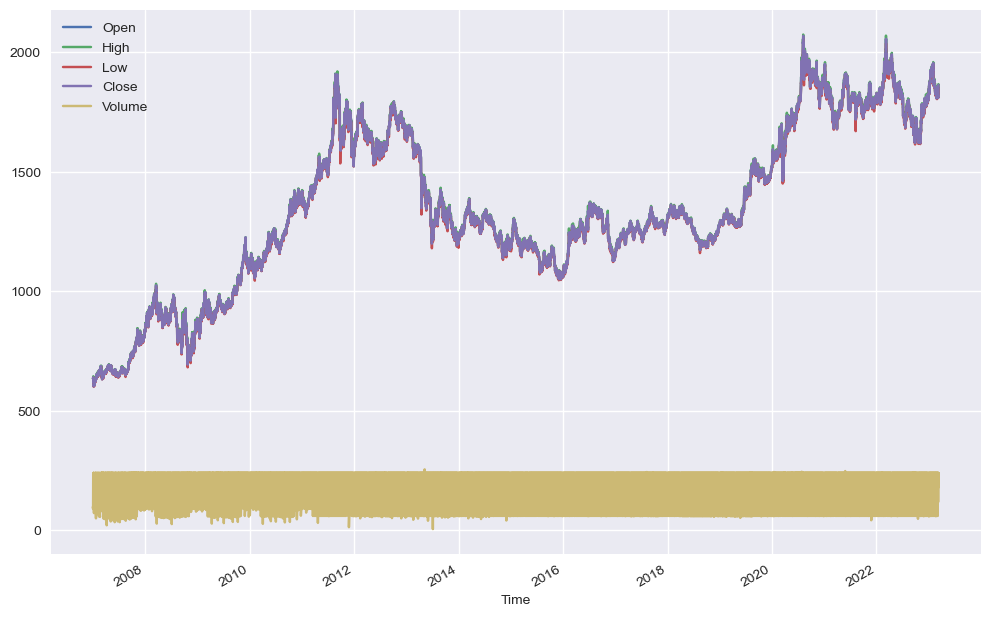

In [10]:
XAUUSD['H4'].plot(figsize=(12, 8))
plt.show()

## ML

### Class and Strategy ML

In [11]:
class Logistic_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [12]:
mainFolder = 'Machine_Learning'
strategy = Logistic_Regression
strategyName = 'Logistic_Regressionon'
account_size = 1000
folder_ML_Strategy = 'Logistic Regression'
subFolder = 'Optimization'

In [13]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'] / data['Close'].shift(1))
        data["direction"] = np.sign(data.returns)
        data.dropna(inplace=True)
        cols = []
        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)
        data['pred'] = 0

        for i in range(self.window_size, len(data)):
            rolling_window_data = data.iloc[i - self.window_size:i]

            lm = LogisticRegression(C=1e6, max_iter=100000, multi_class="ovr")
            lm.fit(rolling_window_data[cols], rolling_window_data['direction'])

            # Predict for the next data point
            pred_value = lm.predict(
                np.array(data[cols].iloc[i]).reshape(1, -1))
            data.at[data.index[i], 'pred'] = np.sign(pred_value[0])

        self.model = lm
        self.data_train = data.copy()

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100)
        result = backtest.run()
        return result

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## TF D1

In [14]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'D1'

### Window size 1 year

In [15]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [16]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [17]:
test = ml.Run()

In [18]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   94.977169
Equity Final [$]                     1002.342
Equity Peak [$]                       1497.98
Return [%]                             0.2342
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                    0.011704
Volatility (Ann.) [%]               27.311708
Sharpe Ratio                         0.000429
Sortino Ratio                        0.000604
Calmar Ratio                         0.000166
Max. Drawdown [%]                  -70.365425
Avg. Drawdown [%]                   -7.347649
Max. Drawdown Duration     4230 days 00:00:00
Avg. Drawdown Duration      224 days 00:00:00
# Trades                                 1740
Win Rate [%]                        50.344828
Best Trade [%]                      14.625363
Worst Trade [%]                    -14.484921
Avg. Trade [%]                    

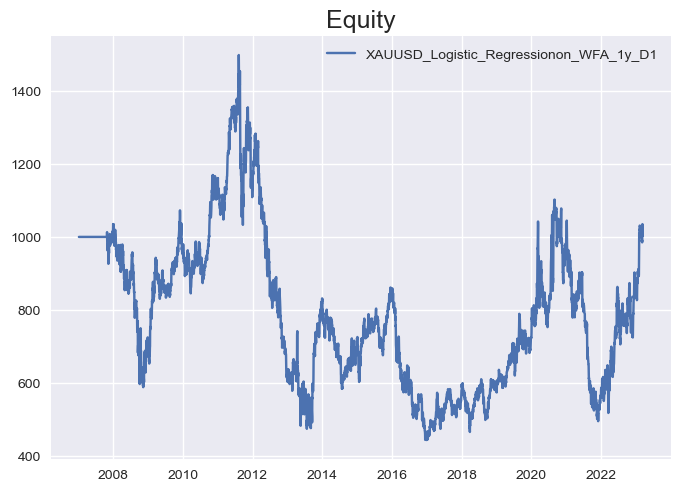

In [19]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [20]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [21]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [22]:
data = XAUUSD['D1']
window_size = 252 * 2
WFA = '2y'

In [23]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [24]:
test = ml.Run()

In [25]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   89.974191
Equity Final [$]                     1823.322
Equity Peak [$]                      2105.954
Return [%]                            82.3322
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                    3.050698
Volatility (Ann.) [%]               13.730005
Sharpe Ratio                         0.222192
Sortino Ratio                        0.324928
Calmar Ratio                         0.066805
Max. Drawdown [%]                   -45.66586
Avg. Drawdown [%]                   -2.817086
Max. Drawdown Duration     4221 days 00:00:00
Avg. Drawdown Duration       84 days 00:00:00
# Trades                                 1301
Win Rate [%]                        51.345119
Best Trade [%]                      13.029007
Worst Trade [%]                    -13.729354
Avg. Trade [%]                    

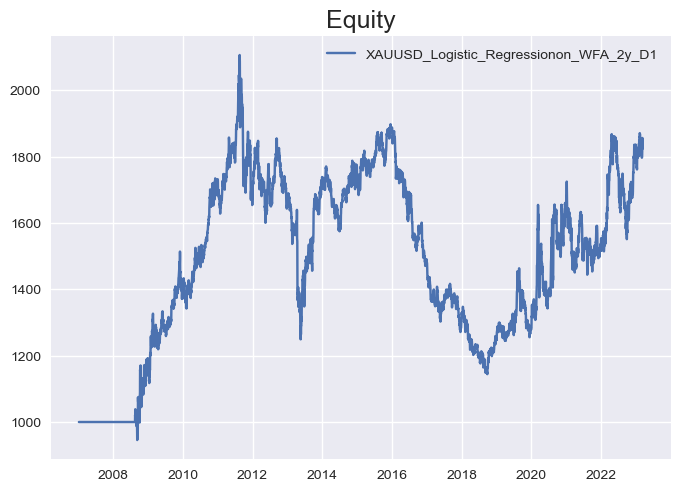

In [26]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [27]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [28]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [29]:
data = XAUUSD['D1']
window_size = 252 * 3
WFA = '3y'

In [30]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [31]:
test = ml.Run()

In [32]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   84.971213
Equity Final [$]                     1189.677
Equity Peak [$]                      1923.649
Return [%]                            18.9677
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                    0.872713
Volatility (Ann.) [%]               15.750232
Sharpe Ratio                          0.05541
Sortino Ratio                        0.078642
Calmar Ratio                          0.01448
Max. Drawdown [%]                  -60.271858
Avg. Drawdown [%]                   -3.687188
Max. Drawdown Duration     4218 days 00:00:00
Avg. Drawdown Duration      131 days 00:00:00
# Trades                                 1045
Win Rate [%]                         50.62201
Best Trade [%]                      17.072513
Worst Trade [%]                    -11.852566
Avg. Trade [%]                    

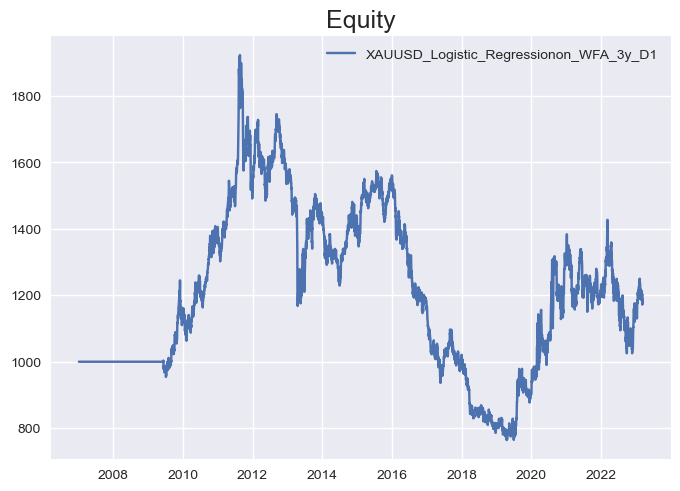

In [33]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [34]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [35]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [36]:
data = XAUUSD['D1']
window_size = 252 * 4
WFA = '4y'

In [37]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [38]:
test = ml.Run()

In [39]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   79.968235
Equity Final [$]                      874.483
Equity Peak [$]                      1799.991
Return [%]                           -12.5517
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                   -0.668765
Volatility (Ann.) [%]               20.331696
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -73.979314
Avg. Drawdown [%]                   -4.087384
Max. Drawdown Duration     4218 days 00:00:00
Avg. Drawdown Duration      138 days 00:00:00
# Trades                                 1003
Win Rate [%]                        48.454636
Best Trade [%]                      61.406634
Worst Trade [%]                     -12.80914
Avg. Trade [%]                    

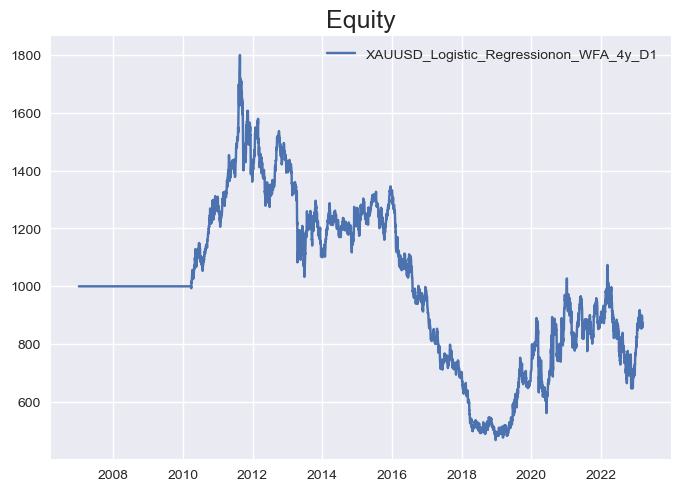

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [41]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [42]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [43]:
data = XAUUSD['D1']
window_size = 252 * 5
WFA = '5y'

In [44]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [45]:
test = ml.Run()

In [46]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   74.965257
Equity Final [$]                      820.375
Equity Peak [$]                      1548.247
Return [%]                           -17.9625
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                   -0.985668
Volatility (Ann.) [%]               24.051437
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -73.488726
Avg. Drawdown [%]                   -6.377267
Max. Drawdown Duration     4218 days 00:00:00
Avg. Drawdown Duration      259 days 00:00:00
# Trades                                  993
Win Rate [%]                        51.762336
Best Trade [%]                      18.875746
Worst Trade [%]                    -17.076071
Avg. Trade [%]                    

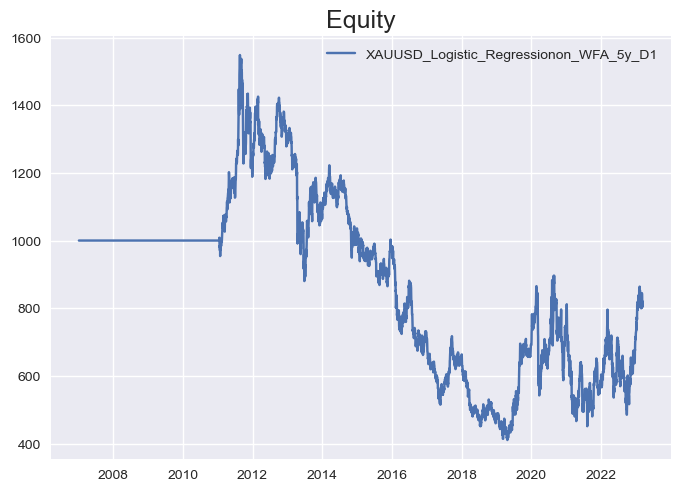

In [47]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [48]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [49]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [50]:
data = XAUUSD['D1']
window_size = 252 * 6
WFA = '6y'

In [51]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [52]:
test = ml.Run()

In [53]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   32.400238
Equity Final [$]                        1.728
Equity Peak [$]                      1001.782
Return [%]                           -99.8272
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                  -27.256378
Volatility (Ann.) [%]               29.045428
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.827507
Avg. Drawdown [%]                  -51.981004
Max. Drawdown Duration     4135 days 00:00:00
Avg. Drawdown Duration     2071 days 00:00:00
# Trades                                  346
Win Rate [%]                        47.976879
Best Trade [%]                       5.664423
Worst Trade [%]                    -15.359851
Avg. Trade [%]                    

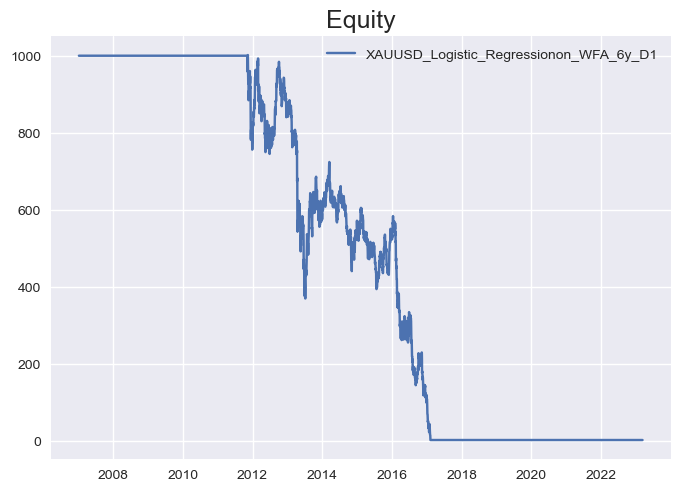

In [54]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [55]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [56]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [57]:
data = XAUUSD['D1']
window_size = 252 * 7
WFA = '7y'

In [58]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [59]:
test = ml.Run()

In [60]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   33.075243
Equity Final [$]                        8.021
Equity Peak [$]                      1137.327
Return [%]                           -99.1979
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                  -21.449489
Volatility (Ann.) [%]               40.460574
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.295365
Avg. Drawdown [%]                  -14.785244
Max. Drawdown Duration     3809 days 00:00:00
Avg. Drawdown Duration      548 days 00:00:00
# Trades                                  443
Win Rate [%]                        47.629797
Best Trade [%]                       5.157463
Worst Trade [%]                    -10.978089
Avg. Trade [%]                    

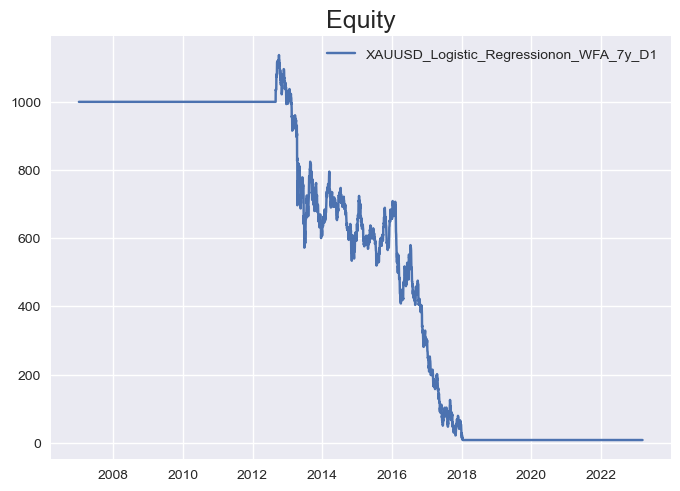

In [61]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [62]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [63]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [64]:
data = XAUUSD['D1']
window_size = 252 * 8
WFA = '8y'

In [65]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [66]:
test = ml.Run()

In [67]:
test

Start                     2007-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   5905 days 00:00:00
Exposure Time [%]                   59.956323
Equity Final [$]                      696.733
Equity Peak [$]                      1211.704
Return [%]                           -30.3267
Buy & Hold Return [%]              206.029817
Return (Ann.) [%]                   -1.791598
Volatility (Ann.) [%]               24.446113
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -70.850389
Avg. Drawdown [%]                  -11.800696
Max. Drawdown Duration     3281 days 00:00:00
Avg. Drawdown Duration      354 days 00:00:00
# Trades                                  899
Win Rate [%]                        50.945495
Best Trade [%]                       5.593803
Worst Trade [%]                    -11.346327
Avg. Trade [%]                    

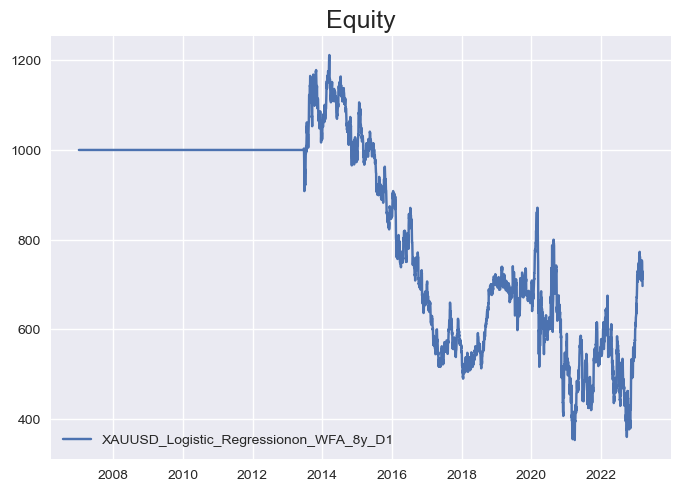

In [68]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [69]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [70]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H4

In [71]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H4'

### Window size 1 year

In [72]:
data = XAUUSD['H4']
window_size = 252 * 6
WFA = '1y'

In [73]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [74]:
test = ml.Run()

In [75]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   5911 days 16:00:00
Exposure Time [%]                   94.174047
Equity Final [$]                      791.518
Equity Peak [$]                      1752.332
Return [%]                           -20.8482
Buy & Hold Return [%]              192.490574
Return (Ann.) [%]                   -1.161749
Volatility (Ann.) [%]               18.518499
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -64.870983
Avg. Drawdown [%]                    -3.13834
Max. Drawdown Duration     4211 days 08:00:00
Avg. Drawdown Duration       72 days 02:00:00
# Trades                                 8306
Win Rate [%]                        51.721647
Best Trade [%]                       6.185074
Worst Trade [%]                     -7.126028
Avg. Trade [%]                    

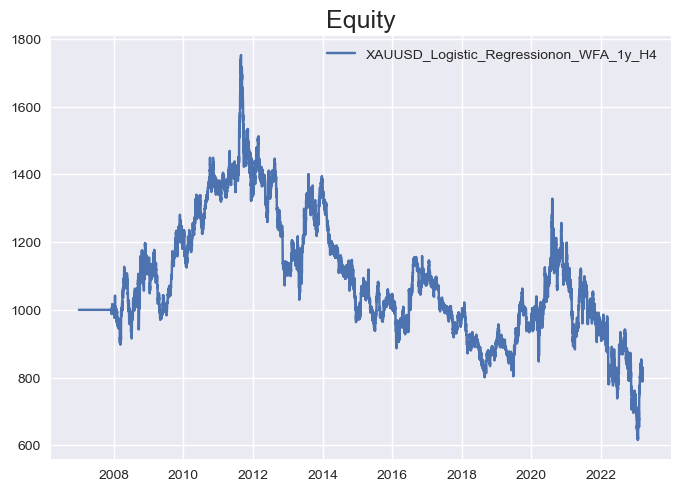

In [76]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [77]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [78]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [79]:
data = XAUUSD['H4']
window_size = 252 * 2 * 6
WFA = '2y'

In [80]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [81]:
test = ml.Run()

In [82]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   5911 days 16:00:00
Exposure Time [%]                   88.351945
Equity Final [$]                       871.59
Equity Peak [$]                      2133.235
Return [%]                            -12.841
Buy & Hold Return [%]              192.490574
Return (Ann.) [%]                   -0.684554
Volatility (Ann.) [%]                19.95011
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -72.783074
Avg. Drawdown [%]                   -1.765969
Max. Drawdown Duration     4216 days 00:00:00
Avg. Drawdown Duration       40 days 22:00:00
# Trades                                 7503
Win Rate [%]                         52.36572
Best Trade [%]                       6.185074
Worst Trade [%]                     -7.714997
Avg. Trade [%]                    

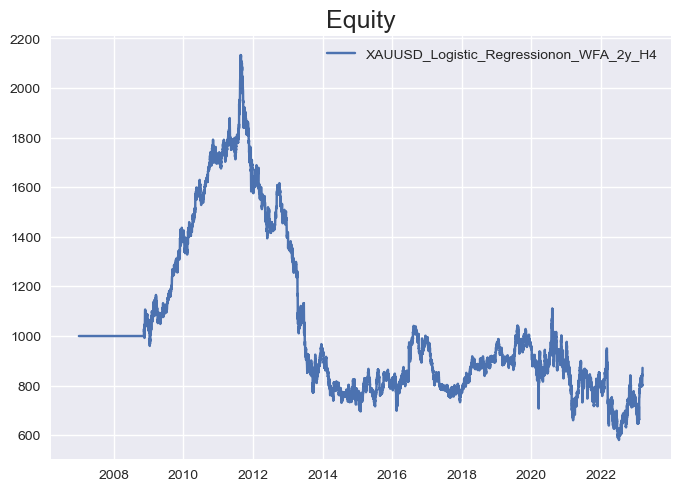

In [83]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [84]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [85]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [86]:
data = XAUUSD['H4']
window_size = 252 * 3 * 6
WFA = '3y'

In [87]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [88]:
test = ml.Run()

In [89]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   5911 days 16:00:00
Exposure Time [%]                   82.529842
Equity Final [$]                     1004.501
Equity Peak [$]                      1809.484
Return [%]                             0.4501
Buy & Hold Return [%]              192.490574
Return (Ann.) [%]                    0.022448
Volatility (Ann.) [%]               18.433869
Sharpe Ratio                         0.001218
Sortino Ratio                        0.001693
Calmar Ratio                         0.000333
Max. Drawdown [%]                  -67.437457
Avg. Drawdown [%]                    -2.05626
Max. Drawdown Duration     4216 days 00:00:00
Avg. Drawdown Duration       52 days 23:00:00
# Trades                                 6500
Win Rate [%]                        53.661538
Best Trade [%]                        5.73108
Worst Trade [%]                     -7.902742
Avg. Trade [%]                    

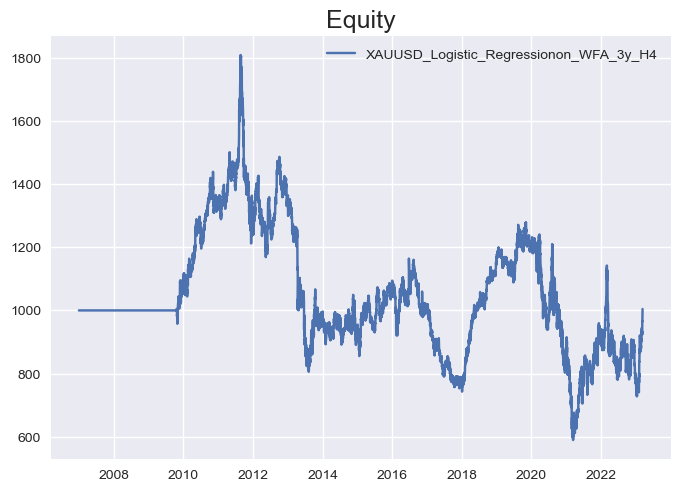

In [90]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [91]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [92]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [93]:
data = XAUUSD['H4']
window_size = 252 * 4 * 6
WFA = '4y'

In [94]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [95]:
test = ml.Run()

In [96]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   5911 days 16:00:00
Exposure Time [%]                   24.982672
Equity Final [$]                        7.285
Equity Peak [$]                      1339.558
Return [%]                           -99.2715
Buy & Hold Return [%]              192.490574
Return (Ann.) [%]                  -21.807721
Volatility (Ann.) [%]               81.092711
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.640478
Avg. Drawdown [%]                   -8.181392
Max. Drawdown Duration     4216 days 00:00:00
Avg. Drawdown Duration      252 days 07:00:00
# Trades                                 1413
Win Rate [%]                          50.2477
Best Trade [%]                       4.522107
Worst Trade [%]                     -7.902742
Avg. Trade [%]                    

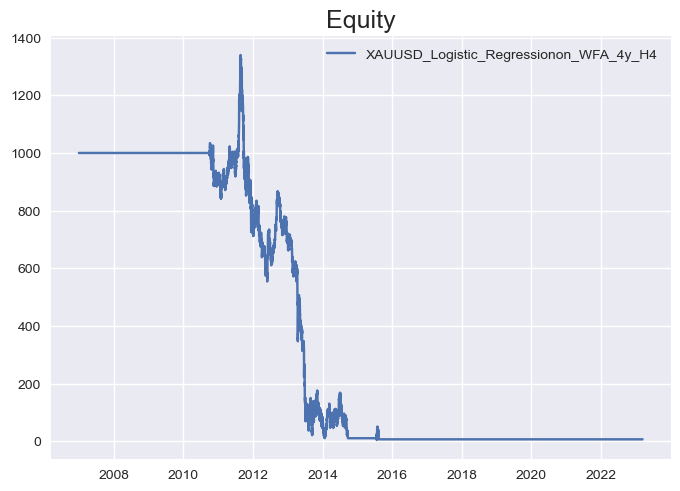

In [97]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [98]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [99]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [100]:
data = XAUUSD['H4']
window_size = 252 * 5 * 6
WFA = '5y'

In [101]:
ml = ML_Regression(data, strategy, start_train,
                   end_train, TF, window_size, 500)

In [102]:
test = ml.Run()

In [103]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 16:00:00
Duration                   5911 days 16:00:00
Exposure Time [%]                    1.721217
Equity Final [$]                         3.22
Equity Peak [$]                       523.116
Return [%]                            -99.356
Buy & Hold Return [%]              192.490574
Return (Ann.) [%]                   -22.28806
Volatility (Ann.) [%]               27.386852
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.384458
Avg. Drawdown [%]                  -49.708881
Max. Drawdown Duration     4203 days 16:00:00
Avg. Drawdown Duration     2102 days 00:00:00
# Trades                                  107
Win Rate [%]                        46.728972
Best Trade [%]                       4.355088
Worst Trade [%]                     -5.180357
Avg. Trade [%]                    

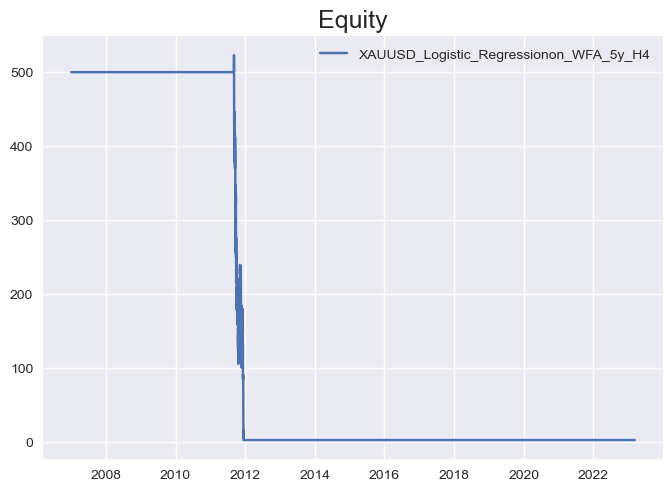

In [104]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [105]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [106]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [107]:
data = XAUUSD['H4']
window_size = 252 * 6 * 6
WFA = '6y'

In [108]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [109]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                    65.06219
Equity Final [$]                      992.467
Equity Peak [$]                      1305.822
Return [%]                            -0.7533
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                   -0.037785
Volatility (Ann.) [%]                22.05322
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -67.935095
Avg. Drawdown [%]                   -5.585939
Max. Drawdown Duration     3442 days 08:00:00
Avg. Drawdown Duration      175 days 03:00:00
# Trades                                 5493
Win Rate [%]                         54.23266
Best Trade [%]                        5.73108
Worst Trade [%]                     -6.243967
Avg. Trade [%]                    

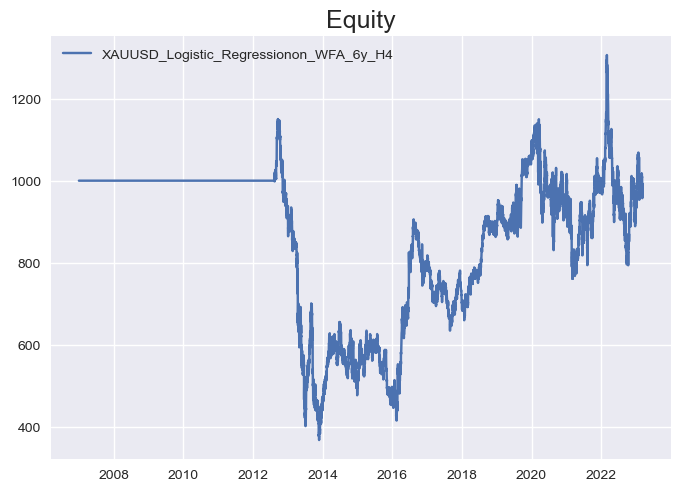

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 7 * 6
WFA = '7y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   59.239863
Equity Final [$]                     1078.219
Equity Peak [$]                      1709.518
Return [%]                             7.8219
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                    0.377113
Volatility (Ann.) [%]               13.068423
Sharpe Ratio                         0.028857
Sortino Ratio                        0.040288
Calmar Ratio                         0.008393
Max. Drawdown [%]                   -44.93442
Avg. Drawdown [%]                   -1.897392
Max. Drawdown Duration     1255 days 20:00:00
Avg. Drawdown Duration       36 days 00:00:00
# Trades                                 5465
Win Rate [%]                        54.565416
Best Trade [%]                        5.73108
Worst Trade [%]                     -5.205037
Avg. Trade [%]                    

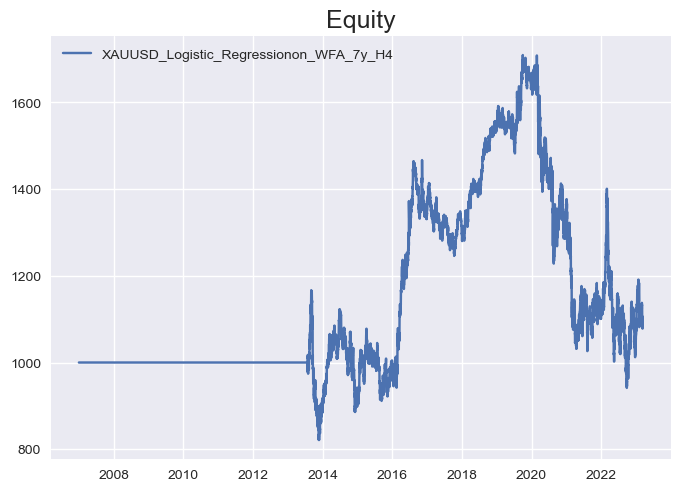

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['H4']
window_size = 252 * 8 * 6
WFA = '8y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-02 00:00:00
End                       2023-03-10 12:00:00
Duration                   5911 days 12:00:00
Exposure Time [%]                   53.417536
Equity Final [$]                     1383.415
Equity Peak [$]                      1840.686
Return [%]                            38.3415
Buy & Hold Return [%]              192.314367
Return (Ann.) [%]                     1.63536
Volatility (Ann.) [%]               11.979533
Sharpe Ratio                         0.136513
Sortino Ratio                        0.199741
Calmar Ratio                         0.046617
Max. Drawdown [%]                  -35.080834
Avg. Drawdown [%]                   -1.288367
Max. Drawdown Duration     1246 days 08:00:00
Avg. Drawdown Duration       20 days 14:00:00
# Trades                                 5240
Win Rate [%]                        53.912214
Best Trade [%]                        5.73108
Worst Trade [%]                     -4.467755
Avg. Trade [%]                    

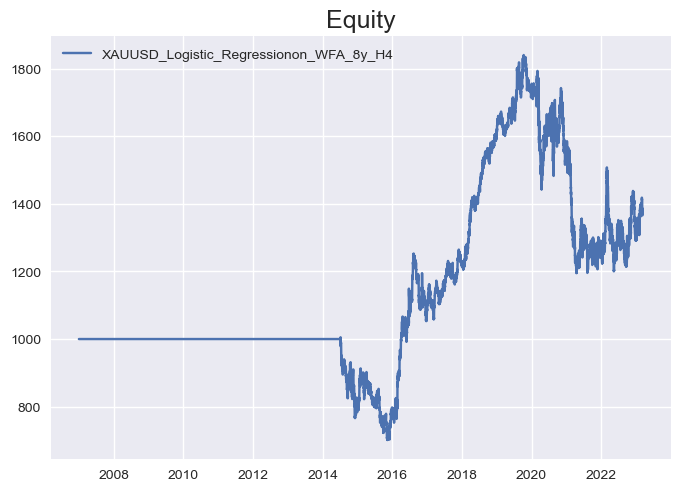

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H1

In [ ]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'H1'

### Window size 1 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 24
WFA = '1y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   93.824211
Equity Final [$]                     4481.844
Equity Peak [$]                      4680.071
Return [%]                           348.1844
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    7.783792
Volatility (Ann.) [%]                9.858876
Sharpe Ratio                         0.789521
Sortino Ratio                        1.266437
Calmar Ratio                         0.390236
Max. Drawdown [%]                  -19.946346
Avg. Drawdown [%]                   -0.541705
Max. Drawdown Duration      503 days 21:00:00
Avg. Drawdown Duration        6 days 18:00:00
# Trades                                28222
Win Rate [%]                        53.316562
Best Trade [%]                       6.254102
Worst Trade [%]                     -7.854516
Avg. Trade [%]                    

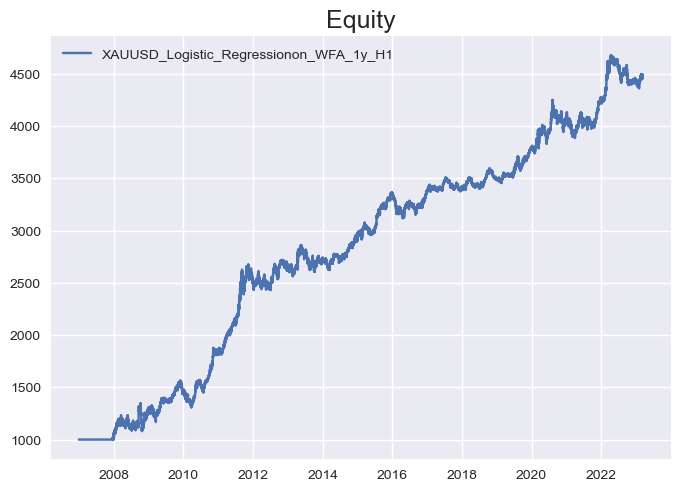

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 2 * 24
WFA = '2y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   87.649443
Equity Final [$]                     3455.661
Equity Peak [$]                      3455.661
Return [%]                           245.5661
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    6.392383
Volatility (Ann.) [%]                 9.56018
Sharpe Ratio                         0.668647
Sortino Ratio                        1.034088
Calmar Ratio                         0.338543
Max. Drawdown [%]                  -18.882055
Avg. Drawdown [%]                   -0.693125
Max. Drawdown Duration     1071 days 08:00:00
Avg. Drawdown Duration        9 days 08:00:00
# Trades                                23023
Win Rate [%]                        53.637667
Best Trade [%]                       4.426038
Worst Trade [%]                     -5.401112
Avg. Trade [%]                    

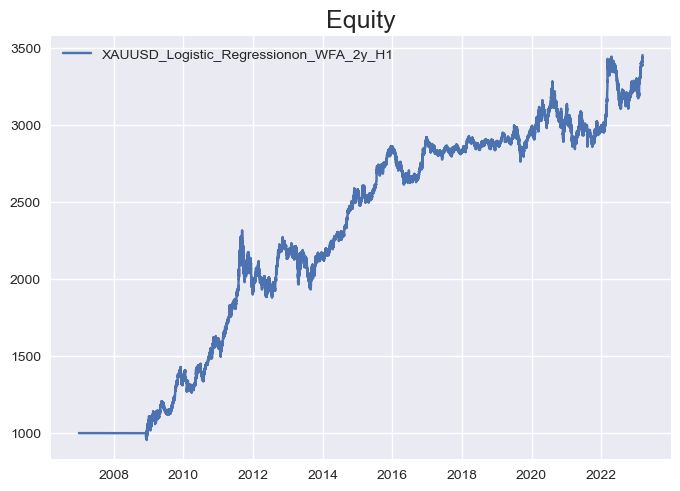

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 3 * 24
WFA = '3y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

Start                     2007-01-01 06:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 10:00:00
Exposure Time [%]                   81.474675
Equity Final [$]                     2603.657
Equity Peak [$]                       2704.48
Return [%]                           160.3657
Buy & Hold Return [%]              191.844558
Return (Ann.) [%]                    4.897908
Volatility (Ann.) [%]               11.207171
Sharpe Ratio                         0.437033
Sortino Ratio                        0.652963
Calmar Ratio                         0.191909
Max. Drawdown [%]                  -25.521974
Avg. Drawdown [%]                   -0.895694
Max. Drawdown Duration     1303 days 04:00:00
Avg. Drawdown Duration       13 days 07:00:00
# Trades                                19828
Win Rate [%]                        54.120436
Best Trade [%]                       3.223874
Worst Trade [%]                     -7.328009
Avg. Trade [%]                    

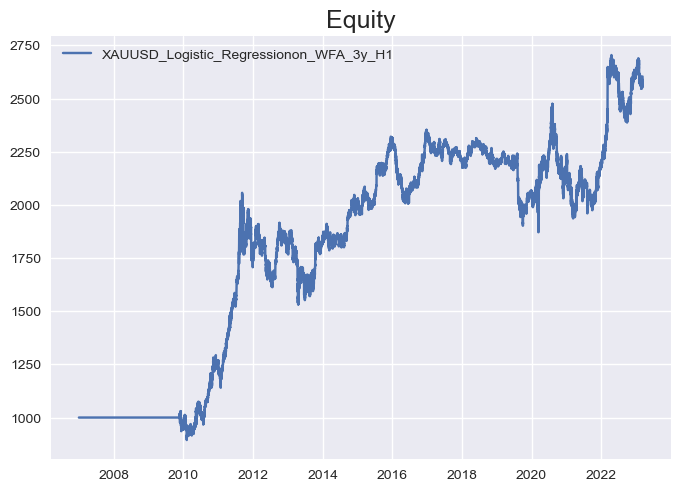

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 4 * 24
WFA = '4y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 5 * 24
WFA = '5y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 6 * 24
WFA = '6y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 7 * 24
WFA = '7y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['H1']
window_size = 252 * 8 * 24
WFA = '8y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

## TF H30

In [ ]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'M30'

### Window size 1 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 48
WFA = '1y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 2 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 2 * 48
WFA = '2y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 3 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 3 * 48
WFA = '3y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 4 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 4 * 48
WFA = '4y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 5 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 5 * 48
WFA = '5y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 6 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 6 * 48
WFA = '6y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 7 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 7 * 48
WFA = '7y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')

### Window size 8 year

In [ ]:
data = XAUUSD['M30']
window_size = 252 * 8 * 48
WFA = '8y'

In [ ]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [ ]:
test = ml.Run()

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

#### Save result 

In [ ]:
filename_train = f'result_{strategyName}_WFA_{WFA}_{TF}.csv'

In [ ]:
save_to_csv(
    test, f'../../out/{mainFolder}/{folder_ML_Strategy}/{subFolder}/{filename_train}')